# Fashion MNIST Classifier with CNN

![](https://pyimagesearch.com/wp-content/uploads/2019/02/fashion_mnist_dataset_sample.png)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. The original MNIST dataset contains a lot of handwritten digits.

### Data Description

* Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total.
* Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.
* The training and test data sets have 785 columns.
* The first column consists of the class labels (see above), and represents the article of clothing.
* The rest of the columns contain the pixel-values of the associated image.



### Data Source
The data is download from kaggle. Here's the link https://www.kaggle.com/zalando-research/fashionmnist

### Labels 
Each training and test example is assigned to one of the following labels as shown below:

* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot



## Importing necessary libraies

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam

Using TensorFlow backend.


## Reading Dataset

### Extracting files from zip folder

In [2]:
import zipfile


zip_ref = zipfile.ZipFile('/content/drive/My Drive/Datasets/Fashion-MNIST_Dataset.zip', 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

### Create dataframes for train and test datasets


In [3]:
train_data = pd.read_csv("/tmp/fashion-mnist_train.csv")
test_data = pd.read_csv("/tmp/fashion-mnist_test.csv")

In [4]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [5]:
(train_data.shape, test_data.shape)

((60000, 785), (10000, 785))



Now it is observed that the first column is the label data and because it has 10 classes so it is going to have from 0 to 9.The remaining columns are the actual pixel data.Here as you can see there are about 784 columns that contain pixel data. Here each row is a different image representation in the form pixel data.

We need to convert the dataframes into numpy arrays of float32 type which is the acceptable form for tensorflow and keras.

In [6]:
train_data = np.array(train_data, dtype='float32')
test_data = np.array(test_data, dtype='float32')

## Spliting datasets into train, test, and validation set



Now let us slice the train arrays into x and y arrays namely x_train,y_train to store all training image data and training label data respectively.

Similarly slice the test arrays into x and y arrays namely x_train,y_train to store all testing image data and testing label data respectively.


Since the image data in x_train and x_test is from 0 to 255 , we need to rescale this from 0 to 1.To do this we need to divide the x_train and x_test by 255 . It's important that the training set and the testing set be preprocessed in the same way

In [7]:
X_train = train_data[:,1:]/255

y_train = train_data[:,0]

X_test= test_data[:,1:]/255

y_test=test_data[:,0]

Now we are gonna split the training data into validation and actual training data for training the model and testing it using the validation set.

In [8]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2,random_state = 13)

Now let us visualise the some samples after the resize of the data which needs to be ready for train the network 

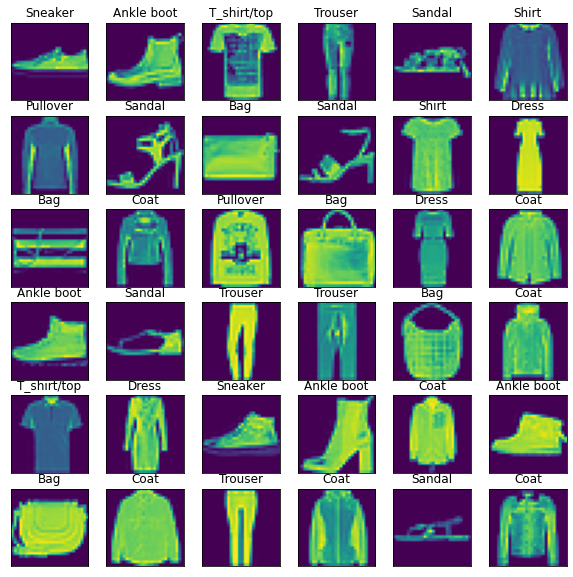

In [9]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape((28,28)))
    label_index = int(y_train[i])
    plt.title(class_names[label_index])
plt.show()

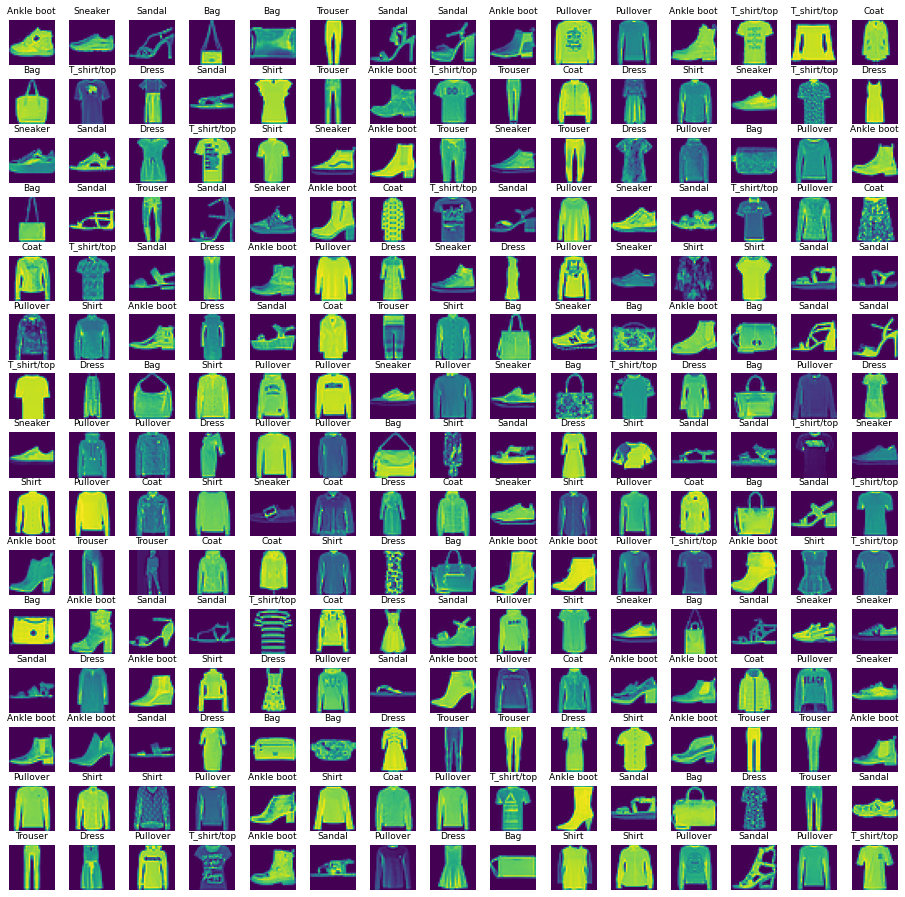

In [10]:
W_grid = 15
L_grid = 15

fig, axes = plt.subplots(L_grid, W_grid, figsize = (16,16))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_train = len(train_data) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow( train_data[index,1:].reshape((28,28)) )
    labelindex = int(train_data[index,0])
    axes[i].set_title(class_names[labelindex], fontsize = 9)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.3)

## Create the Convolution Neural Network (CNN)

Specifying the image rows and image columns. Also specifying the input shape

In [11]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

# specifying batch_size, number of classes and epochs for the model
batch_size = 4096
num_classes = 10
epochs = 200

### Define the model

In [12]:
X_train = X_train.reshape(X_train.shape[0],*input_shape)
X_test = X_test.reshape(X_test.shape[0],*input_shape)

The input layer in our model network is a convolution layer with image_size=32, the weight matrix is of (3,3). The weights are initialized by he_normal and the activation function used is relu. We also use maxpooling to downsample the output

The first hidden layer in model network is a convolution layer with filter size=64 and kernel_size remains same as (3,3). We again downsample the output with maxpooling

The second hidden layer is again a convolution layer.

The third hidden layer, keras.layers.Flatten, transforms the format of the images from a two-dimensional array to a one-dimensional array. This layer unstacks rows of pixels in the image and lining them up and has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two keras.layers.Dense layers. These are densely connected, or fully connected, neural layers. The first Dense layer has 32 nodes (or neurons). The second (and last) layer is a 10-node softmax layer that returns an array of 10 probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the 10 classes.

In [13]:
model = Sequential()

# input layer
model.add(Conv2D(32, kernel_size=(3,3), 
                 activation='relu', 
                 kernel_initializer='he_normal', 
                 input_shape=input_shape))
model.add(MaxPooling2D((2,2))) # down sampling the output instead of 28*28 it is 14*14
model.add(Dropout(0.25))

# first hidden layer
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # down sampling the output instead of 14*14 it is 7*7
model.add(Dropout(0.25))

# second hidden layer
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Dropout(0.4))

# third hidden layer
model.add(Flatten()) # flatten out the layers
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(10, activation='softmax'))

In [14]:
model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 128)        

### Training the model

In [16]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=60,
                    validation_data=(X_test, y_test))

Train on 48000 samples, validate on 10000 samples
Epoch 1/60
48000/48000 [==============================] - 3s 61us/step - loss: 2.0990 - accuracy: 0.2395 - val_loss: 1.5254 - val_accuracy: 0.4834
Epoch 2/60
48000/48000 [==============================] - 1s 13us/step - loss: 1.4224 - accuracy: 0.4787 - val_loss: 0.9857 - val_accuracy: 0.6753
Epoch 3/60
48000/48000 [==============================] - 1s 13us/step - loss: 1.0866 - accuracy: 0.6044 - val_loss: 0.8001 - val_accuracy: 0.7402
Epoch 4/60
48000/48000 [==============================] - 1s 13us/step - loss: 0.9118 - accuracy: 0.6694 - val_loss: 0.6910 - val_accuracy: 0.7631
Epoch 5/60
48000/48000 [==============================] - 1s 13us/step - loss: 0.8163 - accuracy: 0.7040 - val_loss: 0.6297 - val_accuracy: 0.7776
Epoch 6/60
48000/48000 [==============================] - 1s 14us/step - loss: 0.7578 - accuracy: 0.7211 - val_loss: 0.5857 - val_accuracy: 0.7868
Epoch 7/60
48000/48000 [==============================] - 1s 14us/st

Let us plot the Training Accuracy vs Loss to get a better understanding of the model training.

Text(0.5, 1.0, 'Train - Accuracy')

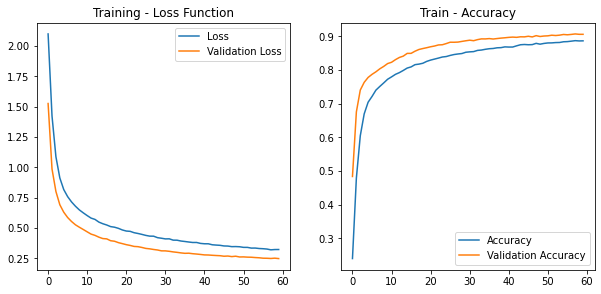

In [17]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

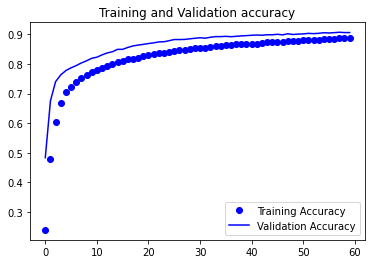

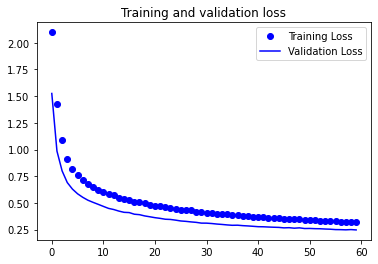

In [18]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Result

In [19]:
score = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.24730223126411438
Test accuracy: 0.9057999849319458


## Classification report

In [20]:


#Get the predictions for the test data
predicted_classes = model.predict_classes(X_test)

#Get the indices to be plotted
correct = np.nonzero(predicted_classes==y_test)[0]
incorrect = np.nonzero(predicted_classes!=y_test)[0]
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_test, predicted_classes, target_names=target_names))



              precision    recall  f1-score   support

     Class 0       0.83      0.87      0.85      1000
     Class 1       0.99      0.98      0.99      1000
     Class 2       0.85      0.86      0.86      1000
     Class 3       0.92      0.92      0.92      1000
     Class 4       0.85      0.88      0.86      1000
     Class 5       0.99      0.96      0.98      1000
     Class 6       0.74      0.67      0.70      1000
     Class 7       0.93      0.97      0.95      1000
     Class 8       0.98      0.98      0.98      1000
     Class 9       0.97      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000





It's apparent that our classifier is underperforming for class 6 in terms of both precision and recall. For class 2, classifier is slightly lacking recall (i.e. missed) whereas it is slightly lacking precision for class 4.

Perhaps we would gain more insight after visualizing the correct and incorrect predictions.

Let us examine the test label and check if it the right classification or not.


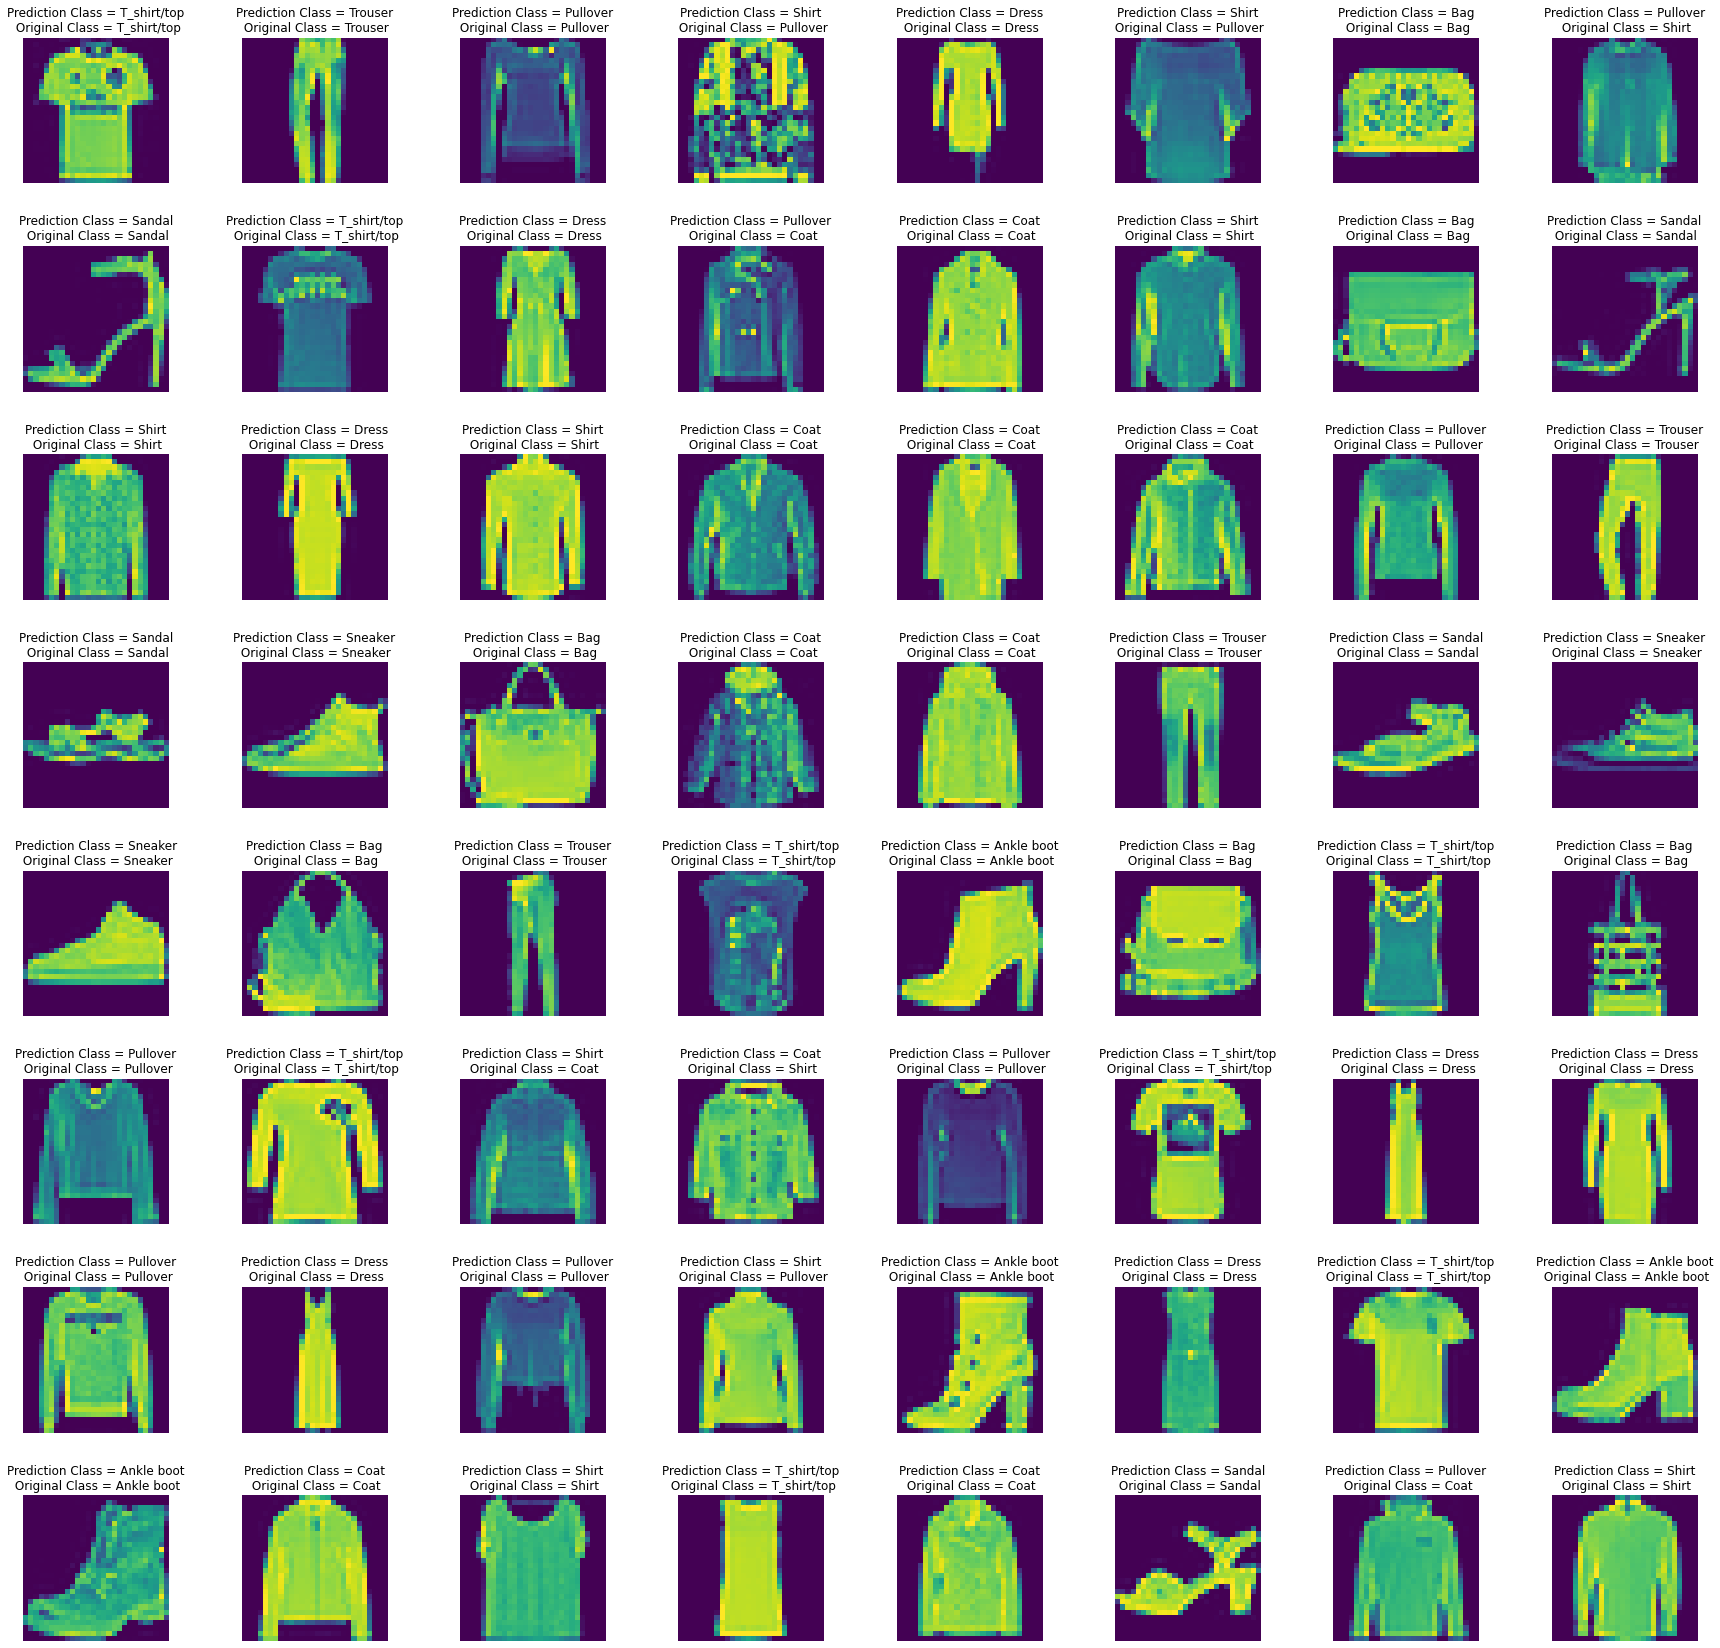

In [21]:
L = 8
W = 8
fig, axes = plt.subplots(L, W, figsize = (30,30))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    m = np.round(predicted_classes[i],0)
    n = np.int(y_test[i])
    axes[i].imshow(X_test[i].reshape(28,28))
    axes[i].set_title(f"Prediction Class = {class_names[m]}\n Original Class = {class_names[n]}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

Visualizing some missed classification

In [22]:
no_match = X_test[(predicted_classes!=y_test)]
no_match_pred = predicted_classes[(predicted_classes!=y_test)]
no_match_actual = y_test[(predicted_classes!=y_test)]

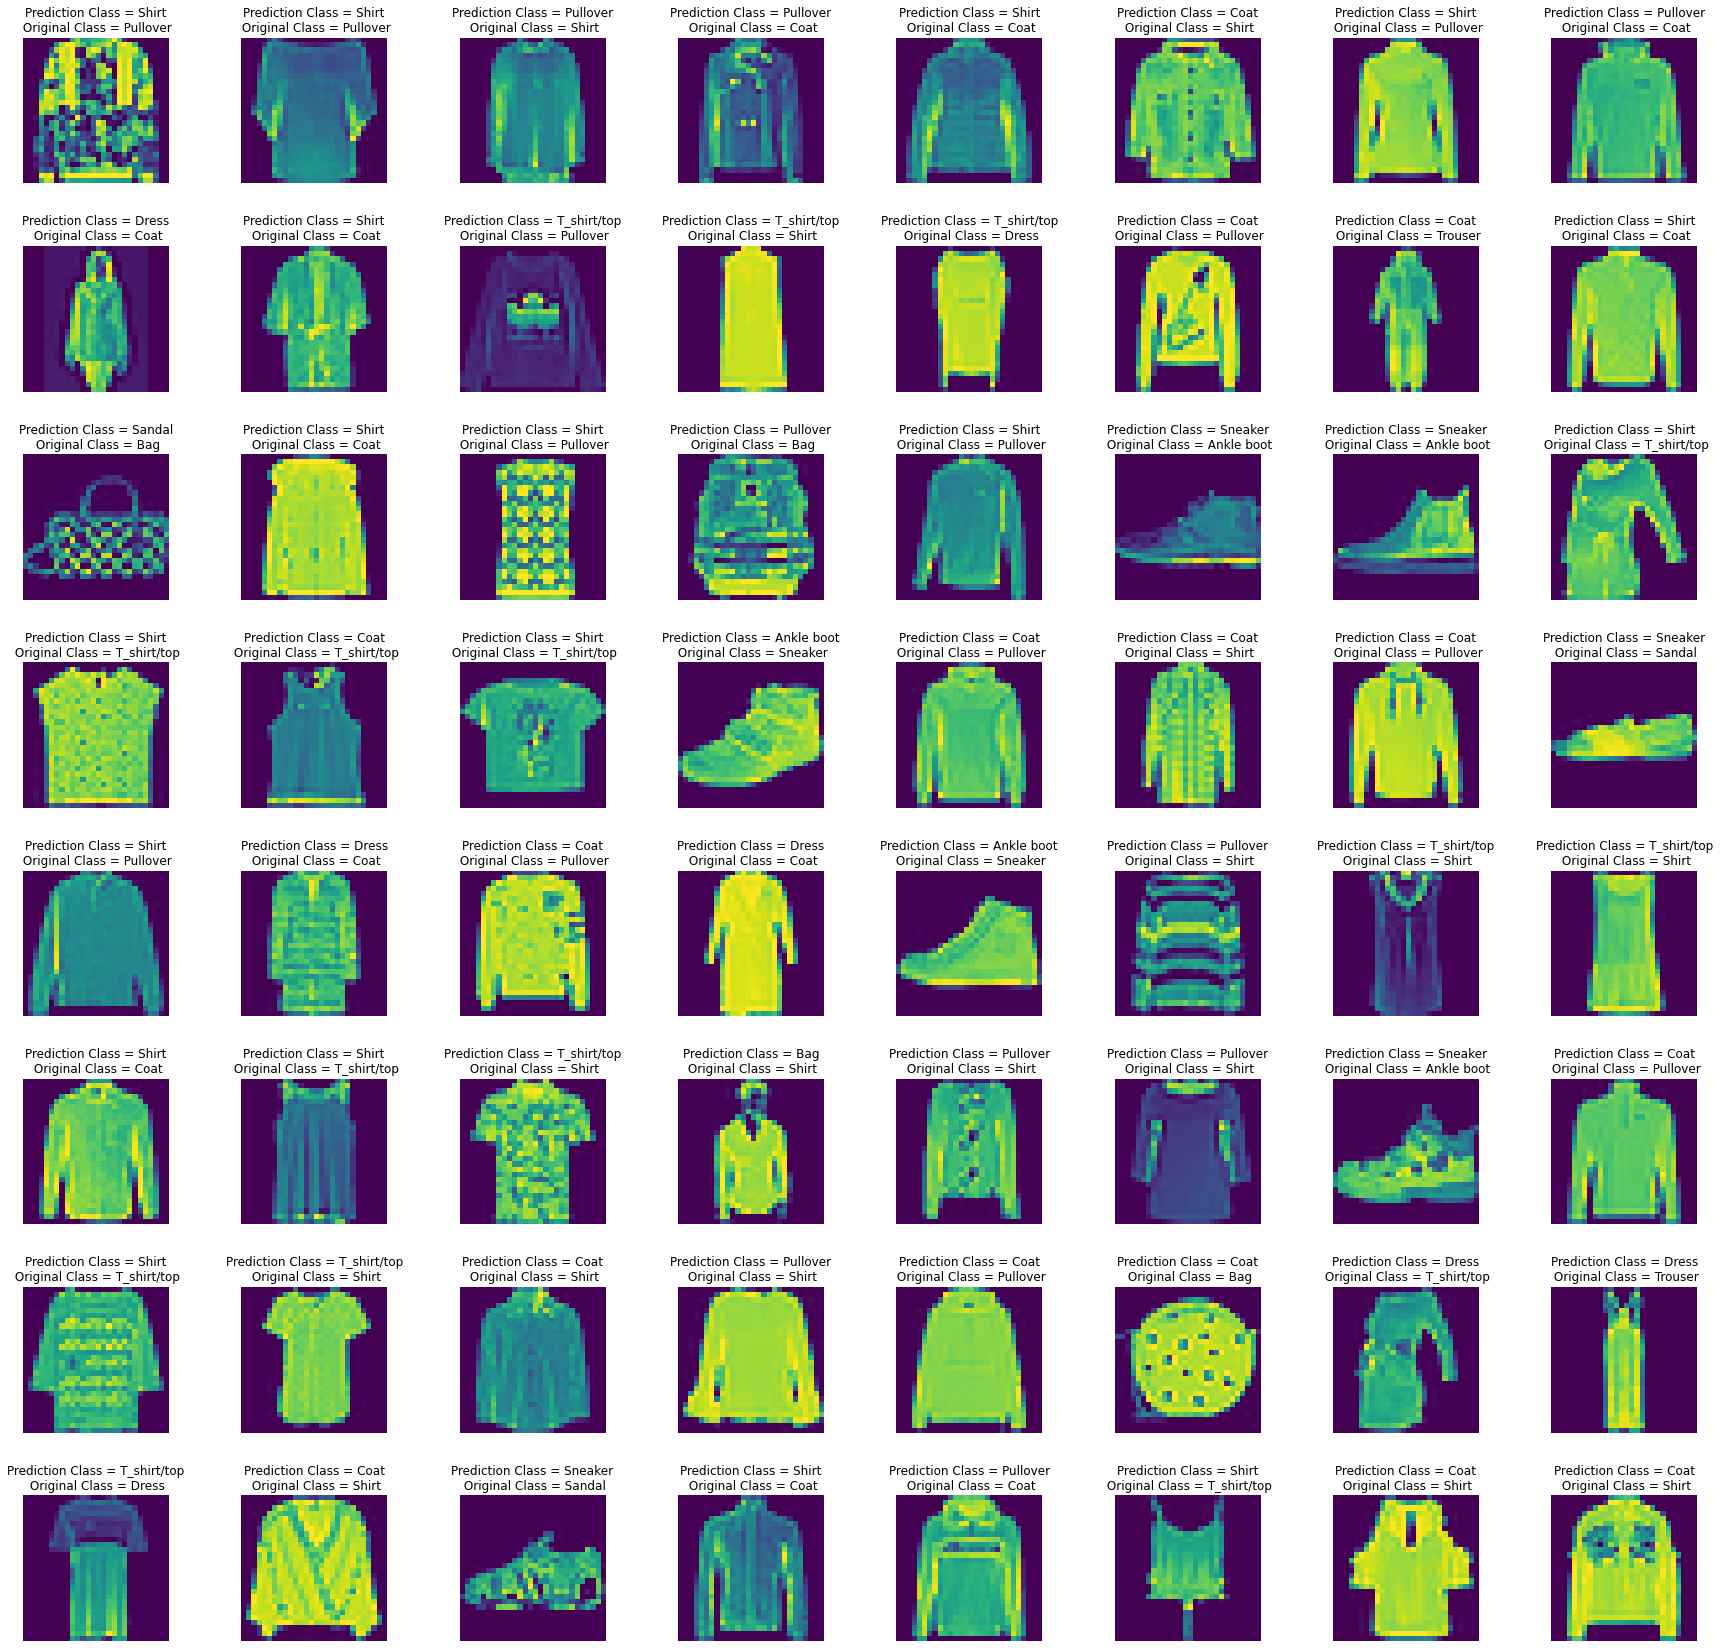

In [23]:
L = 8
W = 8
fig, axes = plt.subplots(L, W, figsize = (30,30))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    m = np.round(no_match_pred[i],0)
    n = np.int(no_match_actual[i])
    axes[i].imshow(no_match[i].reshape(28,28))
    axes[i].set_title(f"Prediction Class = {class_names[m]}\n Original Class = {class_names[n]}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)